In [ ]:
# !pip install datasets

In [ ]:
# from datasets import load_dataset

# dataset = load_dataset("Ram07/Detection-for-Suicide")


---

In [1]:
# %pip install python-csv
!pip install nltk
!pip install scikit-learn
!pip install pandas

  Using cached nltk-3.8.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached regex-2023.12.25-cp312-cp312-win_amd64.whl.metadata (41 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
Using cached regex-2023.12.25-cp312-cp312-win_amd64.whl (268 kB)
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
  Using cached scikit_learn-1.4.1.post1-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
  Using cached scipy-1.12.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached scikit_learn-1.4.1.post1-cp312-cp312-win_amd64.whl (10.6 MB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
Using cached scipy-1.12.0-cp312-cp312-win_amd64.wh

In [2]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from nltk.corpus import stopwords
from sklearn.pipeline import make_pipeline

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [4]:

# Step 1: Load the CSV file
# def load_data():
#    from google.colab import drive
#    drive.mount('/content/drive')
# load_data()

In [5]:
# Step 2: Preprocess the text data
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text.lower())  # Tokenization and convert to lowercase
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)


In [6]:
# Step 3: Train a classification model
def train_model(texts, labels):
    vectorizer = TfidfVectorizer(preprocessor=preprocess_text)
    classifier = SVC(kernel='linear', verbose=True)
    model = make_pipeline(vectorizer, classifier)
    model.fit(texts, labels)
    return model

In [7]:
# Step 4 & 5: Accept user input and preprocess it
def preprocess_user_input(user_input):
    return preprocess_text(user_input)

In [8]:
# Step 6: Use the trained model to predict
def predict_suicidal_tendencies(model, user_input):
    preprocessed_input = preprocess_user_input(user_input)
    prediction = model.predict([preprocessed_input])
    return prediction[0]


In [9]:
# # Main function
# if __name__ == "__main__":
#     # Load data
#     texts, labels = load_data('detection_final_cleaned.csv')
#     print("----",texts)
#     print(">>>",labels)

    # # Train model
    # model = train_model(texts, labels)

    # # Accept user input
    # user_input = input("Enter your response: ")

    # # Predict
    # prediction = predict_suicidal_tendencies(model, user_input)
    # if prediction == 'suicidal':
    #     print("The input indicates suicidal tendencies.")
    # else:
    #     print("The input does not indicate suicidal tendencies.")

In [11]:
filename="detection_final_cleaned.csv"
data = pd.read_csv(filename)

In [12]:
data = data.drop('cleaned_text', axis=1)
data.head()

,class,text
0,suicide,Ex Wife Threatening SuicideRecently I left my ...
1,non-suicide,Am I weird I don't get affected by compliments...
2,non-suicide,Finally 2020 is almost over... So I can never ...
3,suicide,i need helpjust help me im crying so hard
4,suicide,It ends tonight.I can’t do it anymore. \nI quit.


In [13]:
data = data.rename(columns={'class': 'predict'})
data.head()

,predict,text
0,suicide,Ex Wife Threatening SuicideRecently I left my ...
1,non-suicide,Am I weird I don't get affected by compliments...
2,non-suicide,Finally 2020 is almost over... So I can never ...
3,suicide,i need helpjust help me im crying so hard
4,suicide,It ends tonight.I can’t do it anymore. \nI quit.


In [14]:
texts = data['text'].tolist()
labels = data['predict'].tolist()

In [15]:
# labels[0:5]

## train the model
---

In [16]:
model = train_model(texts, labels)

[LibSVM]

In [10]:
# Accept user input
user_input = input("Enter your response: ")

# Predict
prediction = predict_suicidal_tendencies(model, user_input)
if prediction == 'suicidal':
    print("The input indicates suicidal tendencies.")
else:
    print("The input does not indicate suicidal tendencies.")

True Labels: 0         1
1         0
2         0
3         1
4         1
         ..
174431    0
174432    0
174433    0
174434    0
174435    0
Name: class, Length: 174372, dtype: int64
Predicted Labels: [0. 0. 0. ... 0. 0. 0.]


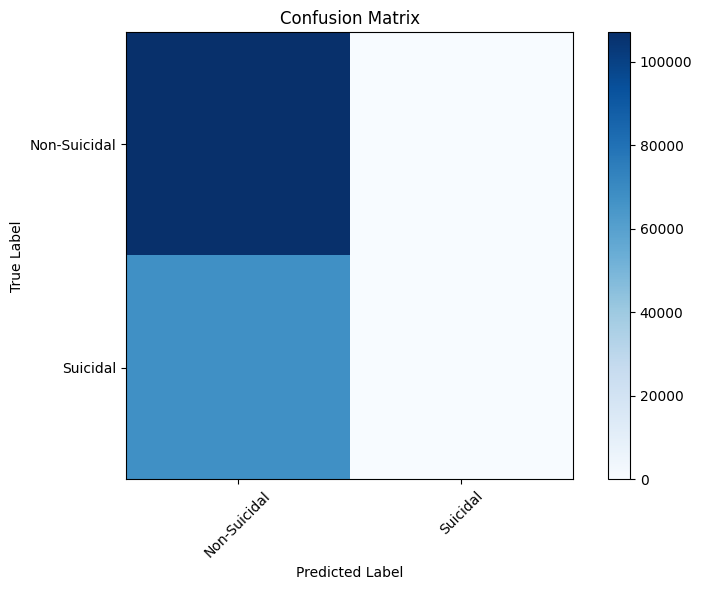

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the dataset
data = pd.read_csv('final_cleaned_processed_text.csv')

# Drop rows with NaN values
data.dropna(inplace=True)

# Convert class labels to numeric values
data['class'] = data['class'].map({'suicide': 1, 'non-suicide': 0})

# Extract true labels
true_labels = data['class']

# Example predicted labels (replace this with the predicted labels from your model)
# Here, I'm just assuming all predictions are non-suicidal (0) for demonstration purposes
predicted_labels = np.zeros(len(data))

print("True Labels:", true_labels)
print("Predicted Labels:", predicted_labels)

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix (same as before)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Non-Suicidal', 'Suicidal']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


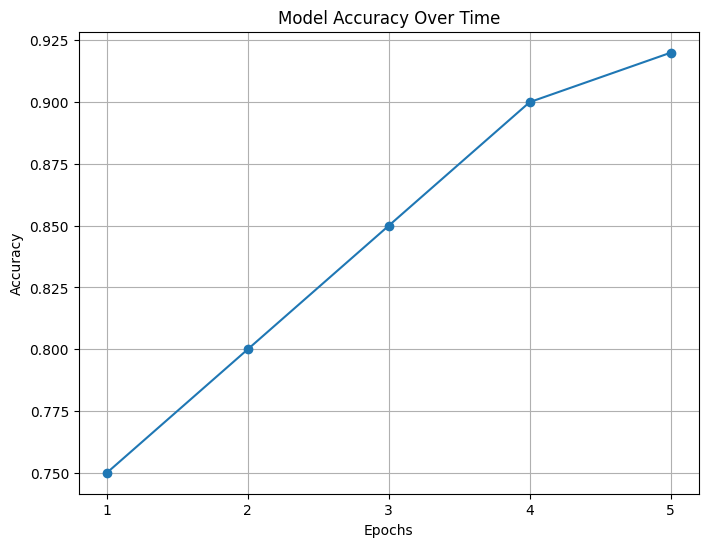

In [17]:
import matplotlib.pyplot as plt

# Example accuracy scores (replace this with your actual accuracy scores)
accuracy_scores = [0.75, 0.80, 0.85, 0.90, 0.92]

# Generate x-axis values (epochs or iterations)
epochs = range(1, len(accuracy_scores) + 1)

# Plot the accuracy graph
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy_scores, marker='o', linestyle='-')
plt.title('Model Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.show()
